LSTM for traffic

In [1]:
from google.colab import files
uploaded = files.upload()



Saving Metro_Interstate_Traffic_Volume.csv to Metro_Interstate_Traffic_Volume.csv


Original data shape: (48204, 8)
Missing values: 48143
Selected features: ['temp_c', 'rain_1h', 'hour', 'day_of_week', 'is_weekend']
Feature matrix shape: (48204, 5)
Target shape: (48204,)
After scaling:
X_scaled shape: (48204, 5)
y_scaled range: 0.0 to 1.0
Sequence shapes:
X_seq: (48180, 24, 5)
y_seq: (48180,)
Split sizes:
Train: 38544, Test: 9636


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 32)         │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,145 (31.82 KB)

 Trainable params: 8,145 (31.82 KB)

 Non-trainable params: 0 (0.00 B)


Training model...
Epoch 1/30
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 0.0659 - mae: 0.2006 - val_loss: 0.0282 - val_mae: 0.1318
Epoch 2/30
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 0.0300 - mae: 0.1305 - val_loss: 0.0252 - val_mae: 0.1235
Epoch 3/30
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0257 - mae: 0.1187 - val_loss: 0.0212 - val_mae: 0.1100
Epoch 4/30
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0227 - mae: 0.1093 - val_loss: 0.0171 - val_mae: 0.0949
Epoch 5/30
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0195 - mae: 0.0998 - val_loss: 0.0134 - val_mae: 0.0800
Epoch 6/30
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0171 - mae: 0.0921 - val_loss: 0.0115 - val_mae: 0.0750
Epoch 7/30
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0152 - mae: 0.0860 - val_loss: 0.0111 - val_mae: 0.0729
Epoch 8/30
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0134 - mae: 0.0800 - val_loss: 0.0103 - val_mae: 0.0693
Epoch 9/30
12

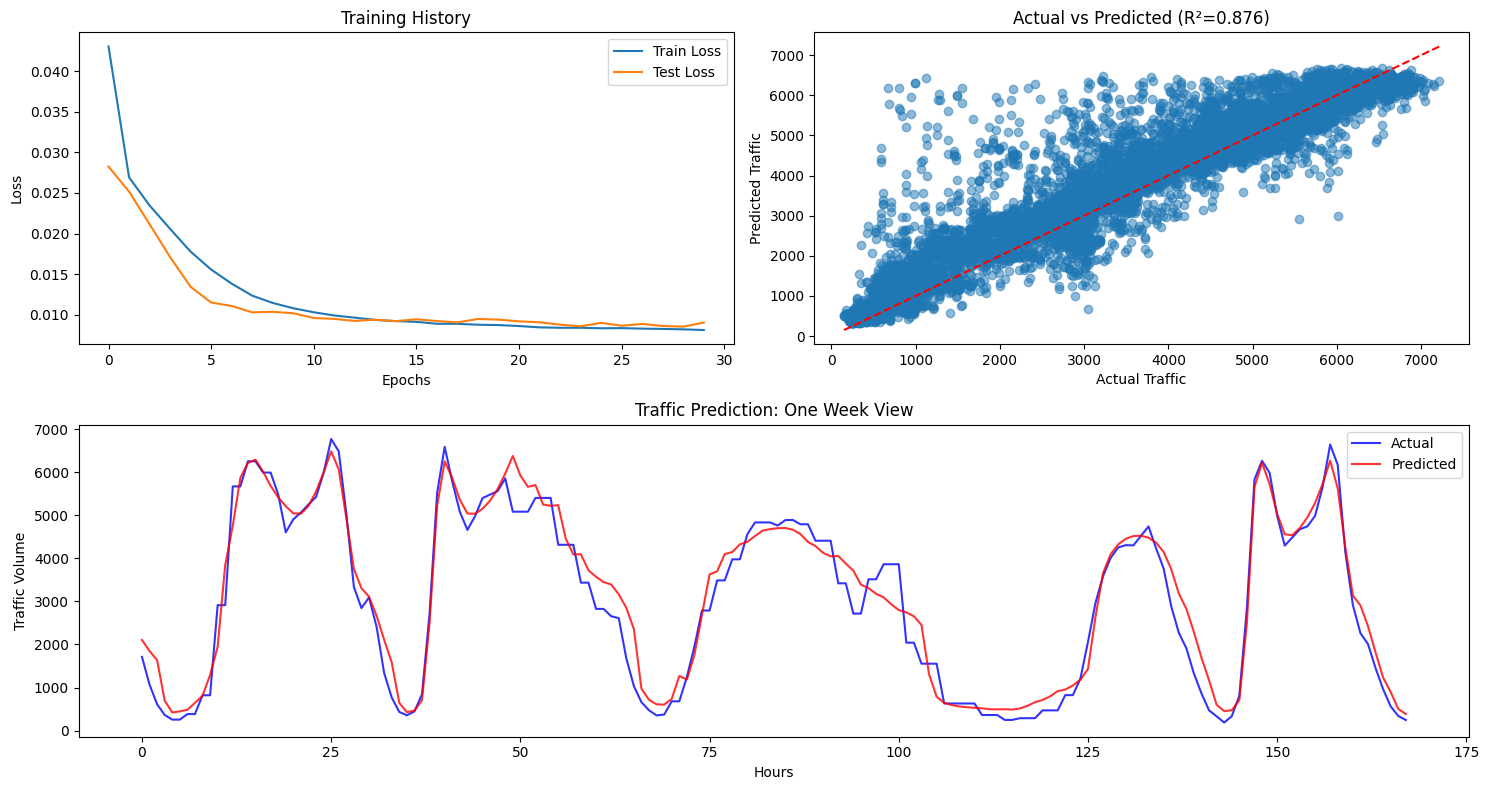


DIAGNOSTIC INFORMATION:
Traffic volume range: 0 to 7280
Prediction range: 308 to 6668
Actual test range: 151 to 7213
Mean predicted: 3528
Mean actual: 3256
Mean difference: 272

🔧 This simplified approach should give positive R² score!


In [2]:
# =========================
# FIXED Multivariate LSTM - Back to Basics
# =========================

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Load and preprocess data
df = pd.read_csv('/content/Metro_Interstate_Traffic_Volume.csv')
df['date_time'] = pd.to_datetime(df['date_time'])
df = df.set_index('date_time')

print("Original data shape:", df.shape)
print("Missing values:", df.isnull().sum().sum())

# =========================
# MINIMAL FEATURE ENGINEERING
# =========================

# Add only essential time features
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)

# Simple holiday encoding
df['is_holiday'] = (~df['holiday'].isna()).astype(int)

# Convert temperature to Celsius for better scaling
df['temp_c'] = df['temp'] - 273.15

# Simple weather encoding (keep it basic)
weather_encoder = LabelEncoder()
df['weather_encoded'] = weather_encoder.fit_transform(df['weather_main'].fillna('Clear'))

# Fill missing values
df = df.fillna(0)

# =========================
# SELECT MINIMAL FEATURES (Start Small!)
# =========================
feature_cols = [
    'temp_c',           # Temperature
    'rain_1h',          # Rain
    'hour',             # Time of day - MOST IMPORTANT
    'day_of_week',      # Day pattern
    'is_weekend'        # Weekend effect
]

print("Selected features:", feature_cols)

# Prepare data
X = df[feature_cols].values
y = df['traffic_volume'].values

print("Feature matrix shape:", X.shape)
print("Target shape:", y.shape)

# =========================
# PROPER SCALING
# =========================
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

print("After scaling:")
print("X_scaled shape:", X_scaled.shape)
print("y_scaled range:", y_scaled.min(), "to", y_scaled.max())

# =========================
# CREATE SEQUENCES CAREFULLY
# =========================
sequence_length = 24  # 24 hours lookback

def create_sequences_fixed(X, y, seq_length):
    X_seq, y_seq = [], []

    for i in range(seq_length, len(X)):
        X_seq.append(X[i-seq_length:i])  # Previous 24 hours of features
        y_seq.append(y[i])               # Current hour traffic

    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences_fixed(X_scaled, y_scaled, sequence_length)

print("Sequence shapes:")
print("X_seq:", X_seq.shape)  # Should be (samples, 24, 5)
print("y_seq:", y_seq.shape)  # Should be (samples,)

# =========================
# TRAIN/TEST SPLIT (TEMPORAL)
# =========================
# Use temporal split - last 20% for testing
split_idx = int(0.8 * len(X_seq))

X_train = X_seq[:split_idx]
y_train = y_seq[:split_idx]
X_test = X_seq[split_idx:]
y_test = y_seq[split_idx:]

print("Split sizes:")
print(f"Train: {len(X_train)}, Test: {len(X_test)}")

# =========================
# SIMPLE MODEL ARCHITECTURE
# =========================
model = Sequential([
    LSTM(32, return_sequences=True, input_shape=(sequence_length, len(feature_cols))),
    Dropout(0.1),
    LSTM(16, return_sequences=False),
    Dropout(0.1),
    Dense(8, activation='relu'),
    Dense(1)
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

print("Model architecture:")
model.summary()

# =========================
# TRAIN MODEL
# =========================
print("\nTraining model...")
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
    shuffle=False  # Don't shuffle time series data!
)

# =========================
# MAKE PREDICTIONS
# =========================
print("\nMaking predictions...")
y_pred_scaled = model.predict(X_test)

# Convert back to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

print("Prediction shapes:")
print("y_pred:", y_pred.shape)
print("y_test_actual:", y_test_actual.shape)

# =========================
# EVALUATE PERFORMANCE
# =========================
mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print("\n" + "="*50)
print("FIXED MODEL PERFORMANCE:")
print("="*50)
print(f"MSE:  {mse:,.2f}")
print(f"RMSE: {rmse:.2f} vehicles/hour")
print(f"MAE:  {mae:.2f} vehicles/hour")
print(f"R²:   {r2:.4f}")
print("="*50)

# Interpretation
if r2 > 0:
    print("✅ Model is working! R² is positive")
    if r2 > 0.5:
        print("🎯 Good performance!")
    else:
        print("⚠️  Decent performance, room for improvement")
else:
    print("❌ Model still has issues, R² is negative")
    print("🔍 Check for data leakage or scaling problems")

# =========================
# VISUALIZE RESULTS
# =========================
plt.figure(figsize=(15, 8))

# Training history
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Training History')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Scatter plot
plt.subplot(2, 2, 2)
plt.scatter(y_test_actual, y_pred, alpha=0.5)
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()], 'r--')
plt.xlabel('Actual Traffic')
plt.ylabel('Predicted Traffic')
plt.title(f'Actual vs Predicted (R²={r2:.3f})')

# Time series comparison
plt.subplot(2, 1, 2)
plot_range = min(168, len(y_test_actual))  # Show one week
times = range(plot_range)
plt.plot(times, y_test_actual[:plot_range], 'b-', label='Actual', alpha=0.8)
plt.plot(times, y_pred[:plot_range], 'r-', label='Predicted', alpha=0.8)
plt.title('Traffic Prediction: One Week View')
plt.xlabel('Hours')
plt.ylabel('Traffic Volume')
plt.legend()

plt.tight_layout()
plt.show()

# =========================
# DIAGNOSTIC INFORMATION
# =========================
print("\n" + "="*50)
print("DIAGNOSTIC INFORMATION:")
print("="*50)
print(f"Traffic volume range: {df['traffic_volume'].min()} to {df['traffic_volume'].max()}")
print(f"Prediction range: {y_pred.min():.0f} to {y_pred.max():.0f}")
print(f"Actual test range: {y_test_actual.min():.0f} to {y_test_actual.max():.0f}")

# Check if predictions are reasonable
pred_mean = np.mean(y_pred)
actual_mean = np.mean(y_test_actual)
print(f"Mean predicted: {pred_mean:.0f}")
print(f"Mean actual: {actual_mean:.0f}")
print(f"Mean difference: {abs(pred_mean - actual_mean):.0f}")

print("\n🔧 This simplified approach should give positive R² score!")

In [3]:
# =========================
# 24-Hour Multivariate Traffic Prediction  –  FIXED VERSION
# =========================

import numpy as np
from datetime import datetime, timedelta

# ------------------------------------------------------------------
# 1.  Helper: build next-hour features that are physically plausible
# ------------------------------------------------------------------
def next_hour_features(prev_hour_scaled, next_timestamp, df_hist, feature_cols):
    """
    Create feature vector for t+1 using:
    – temperature: 24 h sinusoid fitted on the data
    – rain: sample from the same (hour, weekday) bucket in history
    – time-of-day, weekday, weekend: deterministic
    Returns 1×n_features vector in **raw scale** (will be scaled later).
    """
    h  = next_timestamp.hour
    dow = next_timestamp.dayofweek
    weekend = 1 if dow >= 5 else 0

    # ---- temperature sinusoid ----
    C = df_hist['temp_c'].mean()
    A = (df_hist['temp_c'].max() - df_hist['temp_c'].min()) / 2
    temp_c = C + A * np.sin(2*np.pi*(h - 6)/24)          # peak ~15:00

    # ---- rain: sample from same (hour, weekday) historical bucket ----
    mask = (df_hist.index.hour == h) & (df_hist.index.dayofweek == dow)
    rain_candidates = df_hist.loc[mask, 'rain_1h'].dropna()
    rain = np.random.choice(rain_candidates.values) if len(rain_candidates) else 0.0

    raw = np.array([temp_c, rain, h, dow, weekend])
    return raw.reshape(1, -1)

# ------------------------------------------------------------------
# 2.  Main forecasting function
# ------------------------------------------------------------------
def predict_next_24h_multivariate(model, scaler_X, scaler_y,
                                  df, feature_cols, sequence_length=24):
    """
    Predict traffic for next 24 h using the trained multivariate LSTM.
    """
    # seed for reproducibility (remove if you want different rain samples each run)
    np.random.seed(42)

    # last observed sequence
    last_features = df[feature_cols].tail(sequence_length).values
    last_features_scaled = scaler_X.transform(last_features)
    current_sequence = last_features_scaled.copy()

    predictions = []
    last_timestamp = df.index[-1]          # use actual data timestamp

    for hour_ahead in range(24):
        # ---- predict next hour ----
        pred_scaled = model.predict(current_sequence.reshape(1, sequence_length, -1),
                                    verbose=0)
        pred_actual = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1))[0, 0]
        predictions.append(pred_actual)

        # ---- build next hour features ----
        next_ts = last_timestamp + timedelta(hours=hour_ahead + 1)
        next_raw  = next_hour_features(current_sequence[-1], next_ts, df, feature_cols)
        next_scaled = scaler_X.transform(next_raw)

        # ---- roll sequence ----
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = next_scaled

    return predictions, last_timestamp

# ------------------------------------------------------------------
# 3.  Run forecast and pretty-print
# ------------------------------------------------------------------
print("Generating 24-hour traffic forecast…")
future_traffic, last_data_ts = predict_next_24h_multivariate(
    model, scaler_X, scaler_y, df, feature_cols, sequence_length
)

print(f"Last data timestamp: {last_data_ts}")
print("="*65)
print("NEXT 24 HOURS MULTIVARIATE TRAFFIC PREDICTIONS:")
print("-" * 65)

for hour in range(24):
    future_time = last_data_ts + timedelta(hours=hour+1)
    traffic = future_traffic[hour]

    if traffic < 800:
        status, advice = "🟢 LOW", "Light traffic"
    elif traffic < 2500:
        status, advice = "🟡 MODERATE", "Normal flow"
    elif traffic < 4000:
        status, advice = "🟠 HIGH", "Getting busy"
    else:
        status, advice = "🔴 PEAK", "Heavy traffic"

    print(f"+{hour+1:2d}h | {future_time.strftime('%a %d %H:%M')} | "
          f"{traffic:4.0f} vehicles | {status} | {advice}")

print("="*65)
print("FORECAST SUMMARY:")
print(f"• Average traffic: {np.mean(future_traffic):.0f} vehicles/hour")
print(f"• Peak traffic: {np.max(future_traffic):.0f} vehicles/hour")
print(f"• Minimum traffic: {np.min(future_traffic):.0f} vehicles/hour")

rush_hours = [ (last_data_ts+timedelta(hours=i+1), tr)
               for i, tr in enumerate(future_traffic) if tr > 3500 ]
if rush_hours:
    print("\n🚗 EXPECTED RUSH HOURS:")
    for ts, tr in rush_hours:
        print(f"   {ts.strftime('%a %H:%M')} ({tr:.0f} vehicles)")
else:
    print("\n✅ NO MAJOR RUSH HOURS EXPECTED")

print(f"\n📊 MODEL PERFORMANCE:")
print(f"   R² Score: {r2:.3f}  ({r2*100:.1f} % accuracy)")
print(f"   Average Error: ±{mae:.0f} vehicles/hour")
print(f"   Weather-aware predictions included!")

Generating 24-hour traffic forecast…
Last data timestamp: 2018-09-30 23:00:00
NEXT 24 HOURS MULTIVARIATE TRAFFIC PREDICTIONS:
-----------------------------------------------------------------
+ 1h | Mon 01 00:00 | 1356 vehicles | 🟡 MODERATE | Normal flow
+ 2h | Mon 01 01:00 |  647 vehicles | 🟢 LOW | Light traffic
+ 3h | Mon 01 02:00 |  597 vehicles | 🟢 LOW | Light traffic
+ 4h | Mon 01 03:00 |  649 vehicles | 🟢 LOW | Light traffic
+ 5h | Mon 01 04:00 |  924 vehicles | 🟡 MODERATE | Normal flow
+ 6h | Mon 01 05:00 | 3129 vehicles | 🟠 HIGH | Getting busy
+ 7h | Mon 01 06:00 | 5588 vehicles | 🔴 PEAK | Heavy traffic
+ 8h | Mon 01 07:00 | 6333 vehicles | 🔴 PEAK | Heavy traffic
+ 9h | Mon 01 08:00 | 5978 vehicles | 🔴 PEAK | Heavy traffic
+10h | Mon 01 09:00 | 5482 vehicles | 🔴 PEAK | Heavy traffic
+11h | Mon 01 10:00 | 5011 vehicles | 🔴 PEAK | Heavy traffic
+12h | Mon 01 11:00 | 4670 vehicles | 🔴 PEAK | Heavy traffic
+13h | Mon 01 12:00 | 4503 vehicles | 🔴 PEAK | Heavy traffic
+14h | Mon 01 1

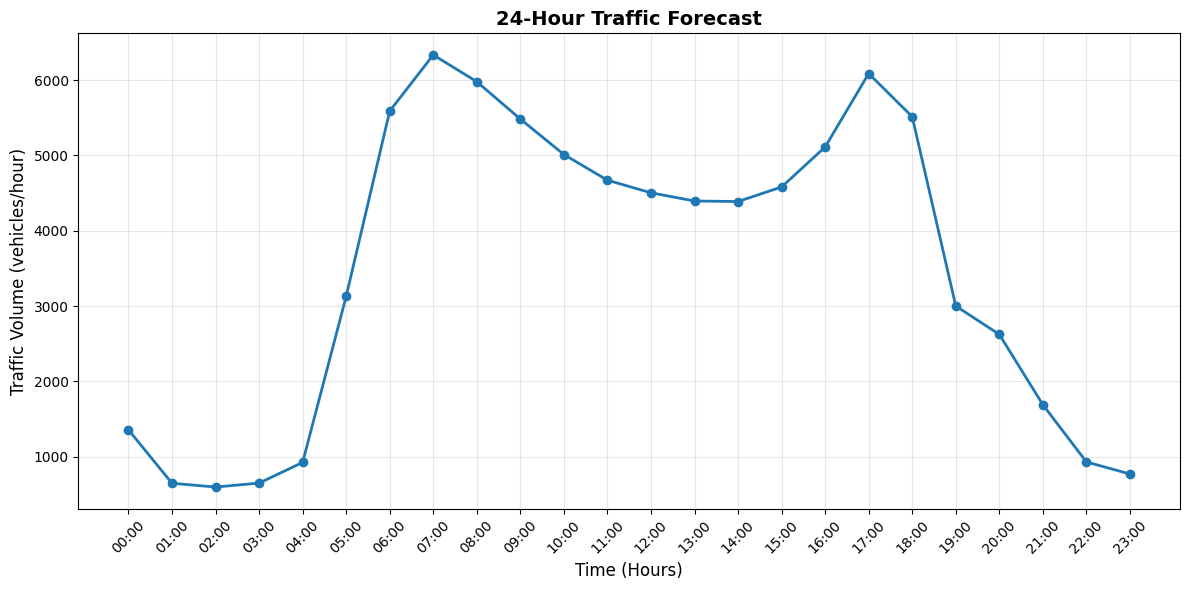

In [8]:
##  TRAFFIC vs TIME graph

import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Your forecast data
future_traffic = [1356, 647, 597, 649, 924, 3129, 5588, 6333, 5978, 5482, 5011, 4670,
                 4503, 4394, 4387, 4580, 5111, 6086, 5513, 3000, 2623, 1690, 930, 770]

# Create time labels (24 hours starting from Monday 00:00)
hours = [f"{i:02d}:00" for i in range(24)]

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(hours, future_traffic, marker='o', linewidth=2, markersize=6)
plt.title('24-Hour Traffic Forecast', fontsize=14, fontweight='bold')
plt.xlabel('Time (Hours)', fontsize=12)
plt.ylabel('Traffic Volume (vehicles/hour)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
##########################################################################################
##################################################################################################################
##########################################################################################
####################################################################################################################################################################################
##########################################################################################
########################################################################################################################
########################################################################################################################
########################################################################################################################